In [27]:
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so

# Para clustering
from sklearn.datasets import make_blobs
from sklearn.datasets import make_circles
from sklearn.preprocessing import MinMaxScaler 
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

**Ejercicio 1**

Trabajamos con las variables "bill_length_mm" y "bill_depth_mm" de pinguinos.

1. Escalar las variables por MinMax (KNN es sensible a las escalas)
2. Para cada uno de los pinguinos 15, 151 y 313 (ver slides), numerar en un grafico los 9 pinguinos mas cercanos, ordenados de más cerca a más lejos.
3. Clasificar cada pingüino utilizando KNN con K = 1, 3 y 9.

In [28]:
# Utilizamos NearestNeighbors para obtener los vecinos más cercanos
from sklearn.neighbors import NearestNeighbors

In [29]:
# Eliminamos datos faltantes y reseteamos los índices, para no tener problemas al graficar
penguins = sns.load_dataset("penguins").dropna().reset_index(drop=True)

# Normalizamos las variables "bill_length_mm" y "bill_depth_mm" por MinMax
penguins[["bill_length_mm", "bill_depth_mm"]] = MinMaxScaler().fit_transform(penguins[["bill_length_mm", "bill_depth_mm"]])

penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,0.254545,0.666667,181.0,3750.0,Male
1,Adelie,Torgersen,0.269091,0.511905,186.0,3800.0,Female
2,Adelie,Torgersen,0.298182,0.583333,195.0,3250.0,Female
3,Adelie,Torgersen,0.167273,0.738095,193.0,3450.0,Female
4,Adelie,Torgersen,0.261818,0.892857,190.0,3650.0,Male


In [30]:
# Nos quedamos solo con largo y profundidad del pico
datos = penguins[["bill_depth_mm", "bill_length_mm"]]

In [31]:
# Veamos primero los 9 vecinos más cercanos del pingüino 151
K = 9
ind = 151
neighbors = NearestNeighbors(n_neighbors=K+1)  # Esta función nos devuelve los más cercanos incluyendo a si mismo, por eso tomamos 10.
neighbors.fit(datos)  # En el ajuste solamente almacenamos los datos

# Ahora podemos buscar los vecinos más cercanos a un punto cualquiera o un conjunto de puntos.
# Tenemos que pasarle un DataFrame
distances, indices = neighbors.kneighbors(datos.iloc[[ind]])

In [32]:
# Nos devuelve un vector de distancias (opcional)
distances.flatten()

array([0.        , 0.04363636, 0.0465499 , 0.04874868, 0.05090909,
       0.05096886, 0.05582947, 0.05778104, 0.06223875, 0.06625228])

Vemos que las distancias están ordenadas de menor a mayor.

In [33]:
# Y un vector de índices

In [34]:
indices.flatten()

array([151, 174, 123, 146, 156, 187, 170, 152, 198, 250], dtype=int64)

C:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_core\plot.py:1491: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):
C:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_core\plot.py:1491: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):
C:\Users\Usuario\anaconda3\Lib\site-packages\seaborn\_core\plot.py:1491: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):


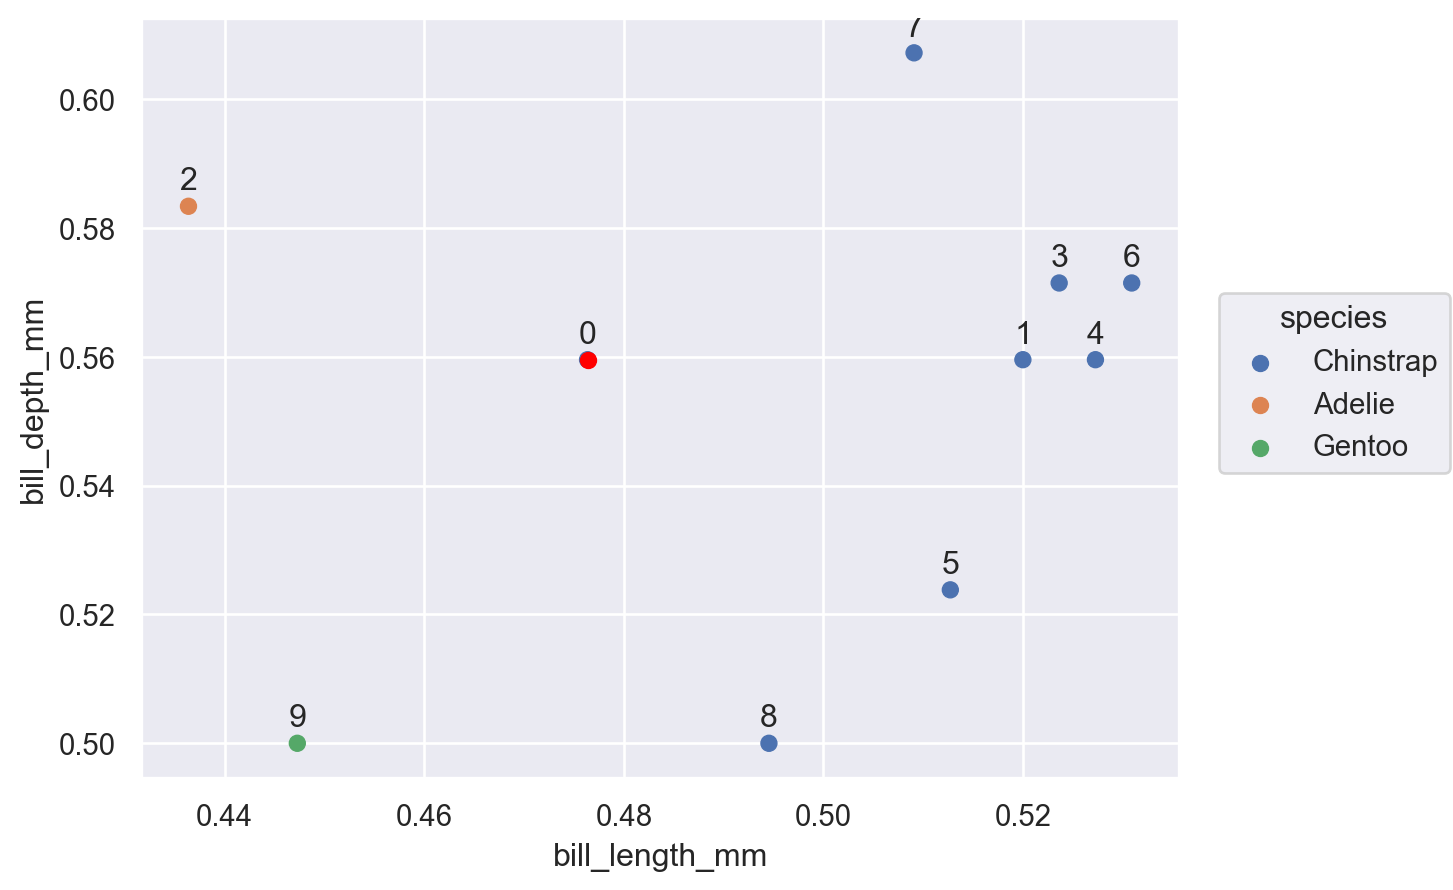

In [35]:
# Graficamos
(
    so.Plot(data = penguins.iloc[indices.flatten()], x = "bill_length_mm", y = "bill_depth_mm",  text = np.arange(K+1).astype(str))
    .add(so.Text(valign = "bottom"))
    .add(so.Dot(), color = "species")
    .add(so.Dot(color = "red"), data = penguins.iloc[[ind]], x = "bill_length_mm", y = "bill_depth_mm")
)

**Ejercicio 2**

1. Implementar una función que reciba un DataFrame (que tenga solo las variables numéricas a utilizar para medir distancias), un vector de categorías (indexado igual que el DataFrame), un índice y un valor de K y devuelva la predicción por K-means para el dato indicado. Importante: debemos ignorar al propio dato en la votación.
2. Aplicar la función a los datos de pingüinos.

**Sugerencia:** para elegir la categoría más votada podemos calcular la moda. El paquete statistics provee el comando `mode`.


In [36]:
# Cargamos el comando mode
import statistics
from statistics import mode

In [37]:
# Item 1

# Antes de hacer la función lo calculamos para un ejemplo.
K = 9
ind = 151
datos = penguins[["bill_depth_mm", "bill_length_mm"]]
categorias = penguins["species"]

neighbors = NearestNeighbors(n_neighbors= K)  # Vamos a eliminar al propio pinguino de los datos, por eso tomamos K.
neighbors.fit(datos.drop([ind]))

distances, indices = neighbors.kneighbors(datos.iloc[[ind]])
votos = categorias[indices.flatten()]

In [38]:
mode(votos)

'Chinstrap'

In [39]:
# Juntamos todo en una función
def mas_votado(datos, categorias, ind, K):
    neighbors = NearestNeighbors(n_neighbors= K)  # Vamos a eliminar al propio pinguino de los datos, por eso tomamos K.
    neighbors.fit(datos.drop([ind]))

    distances, indices = neighbors.kneighbors(datos.iloc[[ind]])
    votos = categorias[indices.flatten()]

    return(mode(votos))

In [40]:
# Item 2 - Aplicamos la función a los datos de pingüinos
datos = penguins[["bill_depth_mm", "bill_length_mm"]]
categorias = penguins["species"]
mas_votado(datos, categorias, 313, 9)

'Gentoo'

**Ejercicio 3**
1. Implementar una función que reciba un DataFrame, un vector de categorías y un valor de K y calcule las predicciones para todos los datos y nos devuelva el porcentaje de aciertos.
2. Aplicar la función a los datos de pingüinos.

In [41]:
# Item 1
def knn_leave_one_out(datos, categorias, K):
    correctos = 0
    total = len(datos)
    for ind in range(total):
        prediccion = mas_votado(datos, categorias, ind, K)
        if(categorias[ind] == prediccion):
            correctos += 1
    return(correctos / total)

In [42]:
# Item 2 - Aplicamos la función a los datos de pingüinos
datos = penguins[["bill_depth_mm", "bill_length_mm"]]
categorias = penguins["species"]
knn_leave_one_out(datos, categorias, 9)

0.960960960960961

**Ejercicio 4**
Utilizando las funciones de los ejercicios anteriores, calcular el valor de $K$ (impar) óptimo para predecir la especie de un pingüino.

In [43]:
for K in range(1,30,2):
    aciertos = knn_leave_one_out(datos, categorias, K)
    print(K, aciertos)

1 0.93993993993994
3 0.9579579579579579
5 0.963963963963964
7 0.9579579579579579
9 0.960960960960961
11 0.96996996996997
13 0.9669669669669669
15 0.963963963963964
17 0.963963963963964
19 0.960960960960961
21 0.9579579579579579
23 0.9579579579579579
25 0.954954954954955
27 0.960960960960961
29 0.954954954954955


## Ejemplo: detección temprana de diabetes

A partir de distintos datos de pacientes queremos detectar tempranamente si ese paciente va a sufrir diabetes.

1. Leer los datos del archivo "diabetes.csv".
2. Separar la columna "Outcome" como variable respuesta y el resto como variables explicativas.
3. Escalar las variables explicativas por MinMax
4. Partir la muestra en un 80% para entrenamiento y un 20% para testeo.
5. Se quiere predecir la variable respuesta por KNN. Calcular el valor óptimo de $K$ optimizando el porcentaje de aciertos en testeo.
7. Para el valor hallado, calcular la matriz de confusión en testeo.

In [44]:
# Utilizamos estos paquetes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [45]:
datos = pd.read_csv("diabetes.csv")
datos.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pedigree,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [46]:
# 2. Separamos la variable respuesta
X = datos.drop("Outcome",axis=1)
y = datos["Outcome"]

# 3. Escalamos X
X = MinMaxScaler().set_output(transform="pandas").fit_transform(X)
X

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Pedigree,Age
0,0.352941,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,0.483333
1,0.058824,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,0.166667
2,0.470588,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,0.183333
3,0.058824,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,0.000000
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,0.200000
...,...,...,...,...,...,...,...,...
763,0.588235,0.507538,0.622951,0.484848,0.212766,0.490313,0.039710,0.700000
764,0.117647,0.613065,0.573770,0.272727,0.000000,0.548435,0.111870,0.100000
765,0.294118,0.608040,0.590164,0.232323,0.132388,0.390462,0.071307,0.150000
766,0.058824,0.633166,0.491803,0.000000,0.000000,0.448584,0.115713,0.433333


In [47]:
neighbor = KNeighborsClassifier(n_neighbors=5)

In [49]:
# Entrenamos utilizando X_train
neighbor.fit(X_train,y_train)

NameError: name 'X_train' is not defined

In [24]:
# Predecimos utilizando X_test
y_pred = neighbor.predict(X_test)
y_pred

NameError: name 'X_test' is not defined

In [90]:
# Calculamos la precisión con accuracy_score
print(accuracy_score(y_test,y_pred))

0.7792207792207793


In [96]:
# Repetimos todo para varios valores de K
for K in range(1,30,2):
    neighbor = KNeighborsClassifier(n_neighbors=K)
    neighbor.fit(X_train,y_train)
    y_pred = neighbor.predict(X_test)
    print(K, accuracy_score(y_test,y_pred))

1 0.6883116883116883
3 0.7727272727272727
5 0.7792207792207793
7 0.7857142857142857
9 0.8051948051948052
11 0.7857142857142857
13 0.7922077922077922
15 0.7922077922077922
17 0.8051948051948052
19 0.7987012987012987
21 0.8116883116883117
23 0.7987012987012987
25 0.7922077922077922
27 0.7987012987012987
29 0.7987012987012987


**Matriz de confusión**
La matriz de confusión $C$ guarda en la coordenada $C_{ij}$ la cantidad de observaciones en el grupo $i$ que fueron clasificadas en el grupo $j$.

Si la variable es binaria:
- $C_{00}$ son los casos negativos clasificados correctamente.
- $C_{01}$ son los casos negativos  clasificados como positivos (falsos positivos).
- $C_{10}$ son los casos positivos  clasificados como negativos (falsos negativos).
- $C_{11}$ son los casos positivos clasificados correctamente.

In [97]:
K = 21
neighbor = KNeighborsClassifier(n_neighbors=K)
neighbor.fit(X_train,y_train)
y_pred = neighbor.predict(X_test)

In [98]:
C = confusion_matrix(y_test,y_pred)
display(C)

array([[98,  9],
       [20, 27]], dtype=int64)

**Ejercicio:** Calcular el coeficiente $C_{01}$ a mano.

In [99]:
sum((y_pred==1) & (y_test==0))

9